This notebook provides code for this post:
[https://paulkepley.com/2020-10-24-HPI_Chorus/](https://paulkepley.com/2020-10-24-HPI_Chorus/)

In this notebook, I'll be generating sheet music and audio from time series data. In particular, I'll consider the state-level [FHFA All-Transactions House Price Index](https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index.aspx). Data will be sourced from [FRED](https://fred.stlouisfed.org/) using the [datapungi_fed](https://github.com/jjotterson/datapungi_fed) FRED API
wrapper. From there, most of this notebook is focused on converting these series into musical notes and exporting the result as sheet music using
[Abjad](http://abjad.mbrsi.org/) and [LilyPond](https://lilypond.org/), and as OGG audio files using Numpy and FFMPEG. 

In total, I generated audio and sheet music for each of the 50 US states, and I also I grouped states by region to produce a sort of HPI chorus.

## Python Package Setup

In [1]:
import os, time, re, shutil, subprocess
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from scipy.fft import fft, ifft, fftshift

from scipy.io.wavfile import write
from scipy.signal import stft
from scipy.signal.windows import tukey

# Get HPI
import datapungi_fed as dpf # pip installed

# Music
import abjad

# Display
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import IPython.display as ipd
from wand.image import Image as WImage
import io

# make output folder
if not os.path.exists("./output"):
    os.mkdir("./output")

NOTE: The Pärt demo requires abjad-ext-tonality


## State-Level HPI from FRED 

To kick things off, we'll download some state-level FHFA All-Transaction HPI data from FRED using the datapugi_fed api.

In [2]:
# Get list of US state abbreviations
state_list_path = "./data/state_list.csv"
state_list = pd.read_csv(state_list_path)
state_list.head()

,state,abbreviation,region
0,Alabama,AL,South
1,Alaska,AK,West
2,Arizona,AZ,West
3,Arkansas,AR,South
4,California,CA,West


In [3]:
# create a dictionary for easily getting abbrevation -->  name
state_dict = dict(zip(state_list['abbreviation'], state_list['state']))

Parse the text file containing my FRED API key on a single line (no quotes, nothing else, just the key). If you don't have one, you can get one [here](https://research.stlouisfed.org/docs/api/api_key.html).

In [4]:
# Get FRED API Key
api_key_path = "./FRED_API_key.txt"
with open(api_key_path, "r") as f:
    api_key = f.readline().splitlines()[0]

In [5]:
# File containing all of the state FHFA all-transactions HPI
state_hpi_path  = "./data/state_hpi.csv"

if not os.path.exists(state_hpi_path):    
    print("Downloading data from FRED")    
    
    for i, state_abbrev in enumerate(state_list["abbreviation"]):        
        state_hpi_mnemonic = state_abbrev + "STHPI"
        state_hpi_curr = dpf.data(api_key).series(state_hpi_mnemonic)
        state_hpi_curr.rename(columns = {state_hpi_mnemonic : state_abbrev},
                             inplace = True)
        
        # Merge all of the HPI dataframes together
        if i == 0:
            state_hpi = state_hpi_curr            
        else:
            state_hpi = pd.merge(
                state_hpi, 
                state_hpi_curr, 
                left_on = "date", 
                right_on = "date", 
                how="outer"
            )            
        
        # pause momentarily
        time.sleep(0.5)

    # finish up
    state_hpi.to_csv(state_hpi_path) 
    (pd.melt(state_hpi, ignore_index=False)
        .rename(columns = {"variable" : "abbreviation", "value" : "hpi"})
        .reset_index()
        .merge(state_list, left_on="abbreviation", right_on="abbreviation")[['date', 'region', 'abbreviation',  'hpi']]
        .to_csv("./output/state_hpi_tidy.csv", index = False))
    
else:
    state_hpi = pd.read_csv(state_hpi_path)
    state_hpi["date"] = pd.to_datetime(state_hpi["date"])
    state_hpi = state_hpi.set_index("date")

Next we'll take a quick look at the data we downloaded.

In [6]:
state_hpi.head()

,AL,AK,AZ,AR,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
date,,,,,,,,,,,,,,,,,,,,,
1975-01-01,72.93,62.85,59.20,66.69,41.59,54.55,61.97,77.80,66.36,74.10,...,69.17,67.89,55.43,55.01,77.38,70.19,46.08,50.13,61.95,49.18
1975-04-01,71.71,64.25,61.04,60.74,42.74,54.36,62.53,89.42,84.11,72.00,...,71.37,68.32,58.46,57.20,76.97,66.70,47.07,63.59,62.83,47.91
1975-07-01,74.09,77.40,59.20,65.52,44.24,54.69,61.56,116.11,67.37,74.43,...,64.58,67.41,56.31,55.32,67.09,67.61,49.31,67.04,64.32,50.32
1975-10-01,70.58,68.91,55.61,62.90,45.79,55.09,61.90,75.43,68.46,73.87,...,61.26,70.77,59.49,60.10,72.79,67.78,47.91,68.02,68.97,53.84
1976-01-01,76.94,71.80,58.09,66.71,47.74,55.01,65.00,80.63,68.43,71.22,...,62.94,69.68,59.11,61.42,117.12,69.23,50.26,62.41,65.67,54.23


The following charts show the FHFA All Transactions HPI for all 50 states, plotted from 2000 onward. In this first chart, we can see some pretty significant variation in the HPI across all 50 states. Some begin and end much higher (such as California), and pretty much all states experienced a strong growth through 2008 followed by a substantial decline during the following recessionary years.

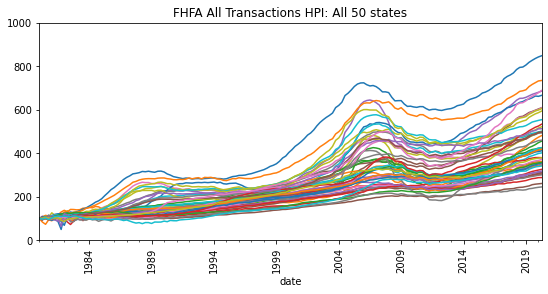

In [7]:
fig, ax = plt.subplots(figsize = (9, 4),facecolor='w')
state_hpi[state_hpi.index >= '1980-01-01'].plot(legend=False, ax=ax)
ax.set_title('FHFA All Transactions HPI: All 50 states')
ax.set_ylim([0,1000])
plt.xticks(rotation='vertical')
plt.show()

Next we'll take a look at HPI by region. 

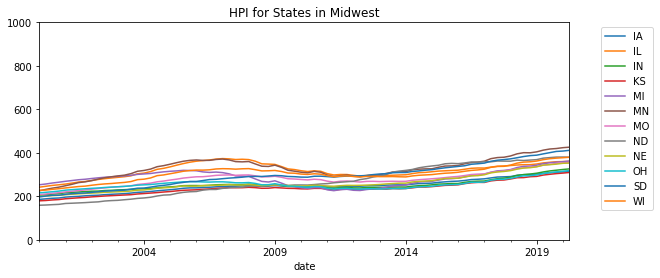

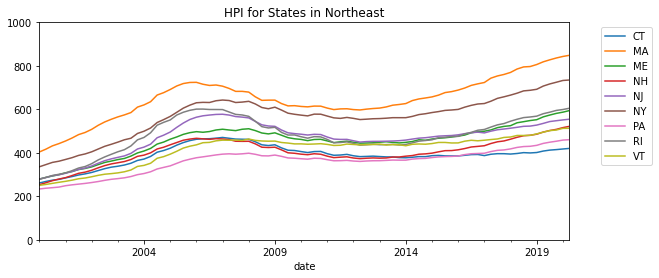

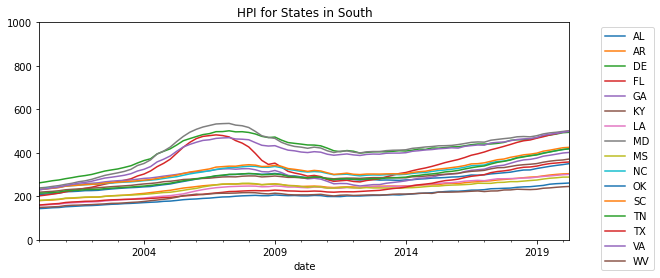

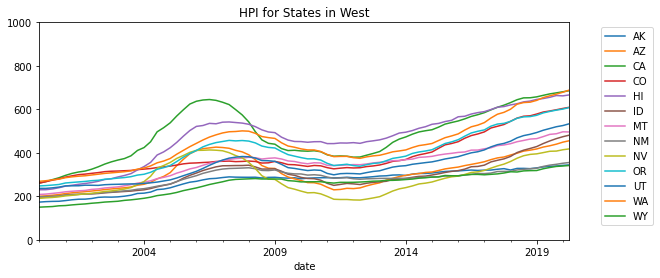

In [8]:
state_hpi_long = (
    state_hpi
    .reset_index()
    .melt(id_vars = 'date', var_name = 'abbreviation', value_name='HPI')
    .merge(state_list, how = 'left')
)

regions = ['Midwest', 'Northeast', 'South', 'West']
for r in regions:
    region_obs_by_state = (state_hpi_long[(state_hpi_long['region'] == r)]
                           .groupby('abbreviation')['date']
                           .count())
    
    fig, ax = plt.subplots(figsize = (9.5, 4),facecolor='w')
    for s in region_obs_by_state.keys():
        single_state_hpi = state_hpi_long[(state_hpi_long['region'] == r) & 
                                          (state_hpi_long['abbreviation'] == s) &
                                          (state_hpi_long['date'] >= '2000-01-01')]
        single_state_hpi.plot(x='date', y='HPI', ax=ax, label=s)        
    plt.legend(bbox_to_anchor = (1.05, 1.0), loc='upper left')
    ax.set_ylim([0,1000])
    ax.set_title('HPI for States in {}'.format(r))
    plt.show()


## Defining Musical Notes

Here I'll grab a list of musical notes / frequencies from [this professor's](https://pages.mtu.edu/~suits/) website. 

In [9]:
note_html = "./data/notefreqs.html"
note_csv  = "./data/musical_notes.csv"

# read csv with musical notes / frequencies if it exists
if os.path.exists(note_csv):
    musical_notes = pd.read_csv("./data/musical_notes.csv")
    
# otherwise, create by parsing a web-page about the topic
else:
    if not os.path.exists(note_html):
        url = "https://pages.mtu.edu/~suits/notefreqs.html"
        req = requests.get(url)
        req_text = req.text

        with open(note_html, 'w') as f:
            f.write(req_text)

    else:
        with open(note_html, 'r') as f:
            req_text = "".join(list(f))

    # build the soup
    soup = BeautifulSoup(req_text, 'html.parser')

    # find the only table, which has the notes & frequencies
    table = soup.find_all('table')[1]
    table_rows = table.find_all('tr')
    table_head = table.find_all('th')

    #table_head = [tc.text for tc in table_head]
    table_head = ['note', 'frequency', 'wavelength']
    table_cells = [tr.find_all('td') for tr in table_rows]
    table_cells = [[tc.text for tc in tr] for tr in table_cells]

    # Create dataframe
    musical_notes = pd.DataFrame(table_cells, columns=table_head)
    for c in table_head[1:]:
        musical_notes[c] = musical_notes[c].apply(lambda x: float(x)) 
    musical_notes['note'] = musical_notes['note'].apply(lambda x: x.strip('\xa0'))

    # define c major scale notes for abjad
    base_sequence = ["c", "cs", "d", "ds", "e", "f", "fs", "g", "gs", "a", "as", "b"]
    sequence = base_sequence[:]
    for i in range(1, 3+1):
        prime_extender = "'" * i
        sequence.extend([e + prime_extender for e in base_sequence])

    # add notes
    musical_notes['note_c_maj'] = ""
    idx_c3 = musical_notes[musical_notes['note'] == 'C3'].index[0]
    for i in range(len(sequence)):
        musical_notes.loc[idx_c3 + i, 'note_c_maj'] = sequence[i]

    # write to file
    musical_notes.to_csv("./data/musical_notes.csv", index=False)

In [10]:
# display
musical_notes[(musical_notes['frequency'] >= 110)].head(n = 10)

,note,frequency,wavelength,note_c_maj
33,A2,110.00,313.64,NaN
34,A#2/Bb2,116.54,296.03,NaN
35,B2,123.47,279.42,NaN
36,C3,130.81,263.74,c
37,C#3/Db3,138.59,248.93,cs
38,D3,146.83,234.96,d
39,D#3/Eb3,155.56,221.77,ds
40,E3,164.81,209.33,e
41,F3,174.61,197.58,f
42,F#3/Gb3,185.00,186.49,fs


## Making Music From Time Series <a id="make_music"></a>

### Writing Sheet Music with Abjad <a id="abjad"></a>

In [11]:
note_to_c_maj_dict = (musical_notes.loc[musical_notes['note_c_maj'] != '', ['note', 'note_c_maj']]
    .set_index('note')
    .to_dict()['note_c_maj'])

In [12]:
def sheet_music_from_notes(notes, scale_dict = note_to_c_maj_dict, title=None, subtitle = None, composer=None):
    # convert the notes to a form Abjad understands using the provided scale_dict
    sheet_music_notes = [scale_dict[n] + '8' if n in scale_dict.keys() else np.nan for n in notes]
    
    # except if we observed a note outside of the scale's range
    if np.nan in sheet_music_notes:
        idx_nan = sheet_music_notes.index(np.nan)
        raise ValueError("Note {} out of range".format(notes[idx_nan]))
            
    # make "music"
    music_container = abjad.Container(' '.join(sheet_music_notes))
    sheet_music = abjad.LilyPondFile.new(music_container)
    
    if title is not None:        
        sheet_music.header_block.title = abjad.Markup(title)
        
    if subtitle is not None:
        sheet_music.header_block.subtitle = abjad.Markup(subtitle)        
        
    if composer is not None:
        sheet_music.header_block.composer = abjad.Markup(composer)
    
    return sheet_music

In [13]:
# music in 4/4 120 bpm, 8th note is base unit
bpm = 240.0
bps = bpm / 60.0

# all of hte following are in seconds
quarter_note_dur = (1.0 / bps)
eighth_note_dur = quarter_note_dur / 2.0
sixteenth_note_dur = quarter_note_dur / 4.0

# sampling frequency in Hz
sampling_freq = 44100 

### Making audio signals

In [14]:
def digitize_signal(y):
    #Note: 32767 = 2**15 - 1
    return np.int16(y/np.max(np.abs(y)) * 32767 * 0.1) 

In [15]:
def make_signal(note_freqs, eighth_note_dur, sampling_freq):
    n_notes = len(note_freqs)
    n_samples_note = int(eighth_note_dur * sampling_freq)    
    n_samples = int(n_notes * n_samples_note)    
    
    signal = np.zeros(n_samples)
    note_window = tukey(n_samples_note, alpha = 0.95)
    note_ts = np.linspace(0, eighth_note_dur, n_samples_note) 

    for i in range(n_notes):
        signal[(i * n_samples_note) : ((i+1) * n_samples_note)] = ((1.0 / note_freqs[i]**2) * note_window * 
                                                                   np.sin(2 * np.pi * note_freqs[i] * note_ts))

    return signal

In [16]:
def series_to_notes(series, musical_notes, eighth_note_dur, note_band = [261, 1047], series_band = None, 
                    sampling_freq=44100):
    # note range
    note_lo, note_hi = note_band
    note_range = note_hi - note_lo
    musical_notes = musical_notes[(musical_notes['frequency'] > note_lo) &
                                  (musical_notes['frequency'] < note_hi)]
    notes = musical_notes['frequency'].values
    notes_in_band = len(notes)
    
    # series range
    if series_band is None:
        series_lo = series.min()
        series_hi = series.max()
    else:
        series_lo, series_hi = series_band
    series_range = series_hi - series_lo
    
    # turn series into notes
    series_note_idxs = np.ceil((notes_in_band - 1) * (series - series_lo) / (series_hi - series_lo) - 0.5)
    series_note_idxs = series_note_idxs.astype('int')
    series_notes     = [musical_notes.iloc[k]['note'] for k in series_note_idxs]
    
    # turn notes into signal
    series_note_freqs = np.array([notes[k] for k in series_note_idxs])
    signal = make_signal(series_note_freqs, eighth_note_dur, sampling_freq)
    
    return signal, series_notes

### Helper function to persist *everything*

The following kludgy function will make / prettify sheet music for later display and will also output audio files.

In [17]:
def persist_music_from_ts(ts, eighth_note_dur, sampling_freq, 
                          series_band = None, note_band = [261, 1047],
                          title = None, subtitle = None, composer=None, 
                          output_path = "./", output_name = "tmp"):
    
    # how many notes?
    n_notes = ts.shape[0]
    
    # if 
    if type(ts) == pd.core.frame.DataFrame:
        ts = ts.values
    elif type(ts) == list:
        ts = np.array(ts)
    
    # use same band for ALL signals when converting
    if series_band is None:
        series_band = [ts.min(), ts.max()]
    
    # get notes
    signal, notes = series_to_notes(
        ts, 
        musical_notes, 
        series_band = series_band,
        note_band = note_band,
        eighth_note_dur = eighth_note_dur, 
        sampling_freq = sampling_freq
    )

    # convert to sheet music
    sheet_music = sheet_music_from_notes(
        notes, 
        title = title,
        subtitle = subtitle, 
        composer = composer
    )

    output_path_no_fmt = "{}/{}".format(output_path, output_name)
       
    # temporarily persist as wav
    output_path_wav = output_path_no_fmt + ".wav"
    subprocess.call(['rm', output_path_wav])
    write(output_path_wav, sampling_freq, digitize_signal(signal))
    
    # delete wav if we can create an ogg instead
    if shutil.which('ffmpeg') is not None:
        output_path_ogg = output_path_no_fmt + ".ogg"
        subprocess.call(['rm', output_path_ogg])
        subprocess.call([
            'ffmpeg', '-i', output_path_wav,
            "-c:a", "libvorbis",
            "-b:a", "128k",            
            output_path_ogg
        ])
        #subprocess.call(['rm', output_path_wav])
            
    # persist as pdf
    output_path_pdf = output_path_no_fmt + ".pdf"
    for x in abjad.persist(sheet_music).as_pdf(pdf_file_path = output_path_pdf, 
                                              remove_ly=True): 
            x

    # persist as png
    output_path_png = output_path_no_fmt + ".png"            
    for x in abjad.persist(sheet_music).as_png(png_file_path = output_path_png, 
                                              remove_ly=True): 
            x
            
    # process the output
    png_img = WImage(filename = output_path_png)
    png_img.trim(color=None, fuzz=0)
    w,h = png_img.size
    pad = min(w,h)
    png_img.border("#fff", int(0.1 * pad), int(0.1 * pad))
    png_img.transform(resize='650x')
    png_img.save(filename = output_path_png)

    return png_img 

### Example: Major Scale

In [18]:
skips = [2,2,1,2,2,2,1]
major_scale = [1]
for i in range(2):
    for s in skips:
        major_scale.append(major_scale[-1] + s)
major_scale = np.array(major_scale)
major_scale = np.append(major_scale, np.flip(major_scale))

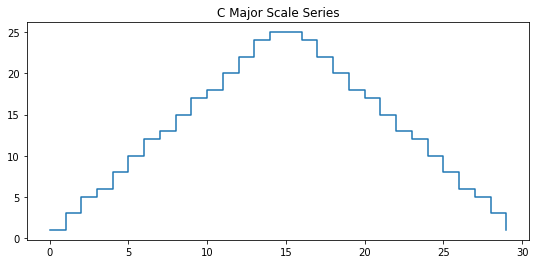

In [19]:
fig, ax = plt.subplots(figsize=(9,4),facecolor='w')
ax.plot(major_scale, drawstyle="steps-post")
ax.set_title("C Major Scale Series")
plt.show()

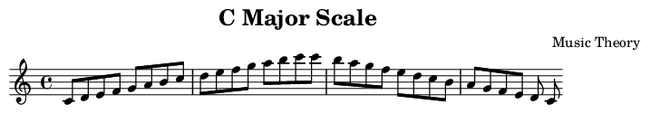

In [20]:
# write sheet music, write ogg
persist_music_from_ts(
    major_scale, 
    eighth_note_dur, 
    sampling_freq,
    title ="C Major Scale",
    composer="Music Theory",
    output_path = "./output/",
    output_name = "major_scale" 
)

In [21]:
ipd.Audio('./output/major_scale.ogg')

### Example: Computer Blips

In [22]:
np.random.seed(1231)
blip_series = np.random.rand(120)
#blip_signal, blip_notes = series_to_notes(blip_series, musical_notes, eighth_note_dur = eighth_note_dur, 
#                         sampling_freq = sampling_freq)

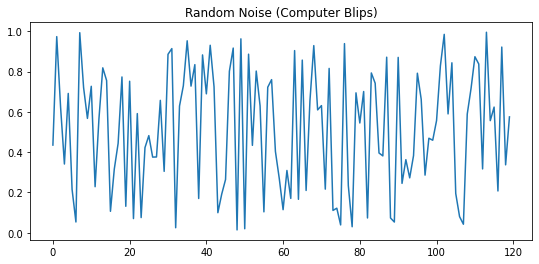

In [23]:
fig, ax = plt.subplots(figsize=(9,4),facecolor='w')
ax.plot(blip_series)
ax.set_title('Random Noise (Computer Blips)')
plt.show()

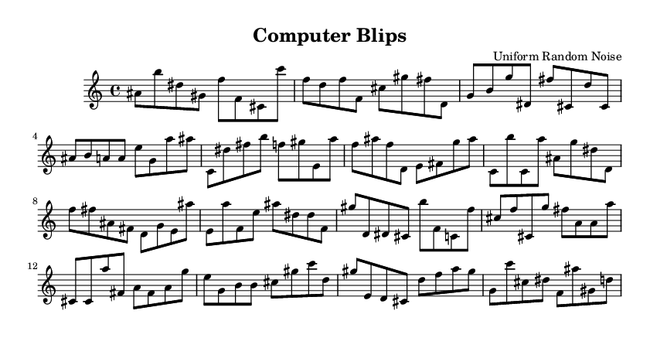

In [24]:
# write sheet music, write ogg
persist_music_from_ts(
    blip_series, 
    eighth_note_dur, 
    sampling_freq, 
    title ="Computer Blips",
    composer="Uniform Random Noise",
    output_path = "./output/",
    output_name = "blips" 
)

In [25]:
ipd.Audio('./output/blips.ogg')

### Example: California HPI

In [26]:
ca_hpi = state_hpi['CA'].values
start = state_hpi['CA'].index.min()
end   = state_hpi['CA'].index.max()

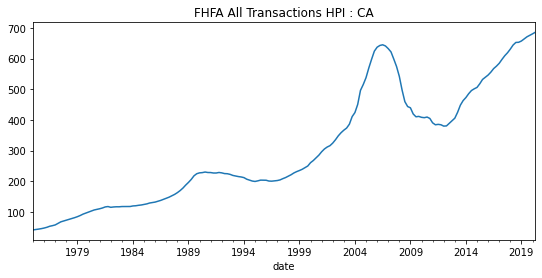

In [27]:
fig, ax = plt.subplots(figsize=(9,4), facecolor='w')
state_hpi['CA'].plot(legend=False, ax=ax)
plt.title("FHFA All Transactions HPI : CA")
plt.show()

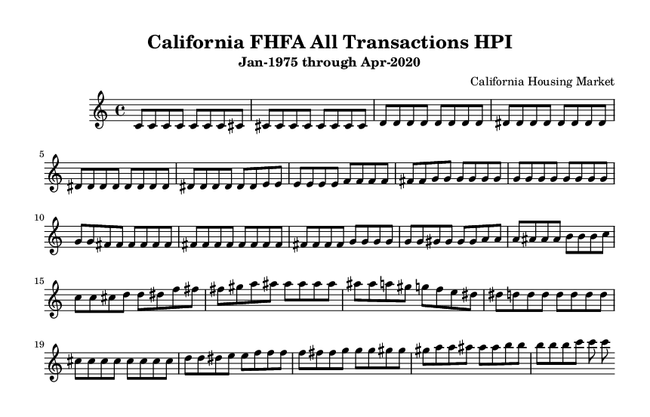

In [28]:
# write sheet music, write ogg
persist_music_from_ts(
    ca_hpi, 
    eighth_note_dur, 
    sampling_freq, 
    title ="{} FHFA All Transactions HPI".format(state_dict['CA']),
    subtitle = "{} through {}".format(start.strftime("%b-%Y"), end.strftime("%b-%Y")), 
    composer="{} Housing Market".format(state_dict['CA']),
    output_path = "./output/",
    output_name = "hpi_CA_1975_2020" 
)

In [29]:
ipd.Audio('./output/hpi_CA_1975_2020.ogg')

## Convert all state HPI's into sheet music

In [30]:
hpi_lo = state_hpi[state_hpi.index >= '2000-01-01'].values.min()
hpi_hi = state_hpi[state_hpi.index >= '2000-01-01'].values.max()
hpi_range = [hpi_lo, hpi_hi]

In [31]:
for state_abbrev in state_list.abbreviation.values:
    state_hpi_ts = state_hpi[state_hpi.index >= '2000-01-01'][state_abbrev]
    start = state_hpi_ts.index.min()
    end = state_hpi_ts.index.max()

    # write sheet music
    persist_music_from_ts(
        state_hpi_ts, 
        eighth_note_dur, 
        sampling_freq, 
        series_band = hpi_range, 
        title ="{} FHFA All Transactions HPI".format(state_dict[state_abbrev]),
        subtitle = "{} through {}".format(start.strftime("%b-%Y"), end.strftime("%b-%Y")), 
        composer="{} Housing Market".format(state_dict[state_abbrev]),
        output_path = "./output/",
        output_name = "hpi_" + state_abbrev
    )

## Combining Many Signals Together

In [32]:
def all_state_hpi(state_hpi, musical_notes, eighth_note_dur, sampling_freq):
    n_notes = state_hpi.shape[0]
    
    # use same band for ALL signals when converting
    series_band = [state_hpi.values.min(), state_hpi.values.max()]
    
    # get all of the signals
    all_state_signals = dict()    
    for state_abbrev in state_hpi.columns:
        all_state_signals[state_abbrev], _ = series_to_notes(
            state_hpi[state_abbrev].values, 
            musical_notes, 
            series_band = series_band,
            eighth_note_dur = eighth_note_dur, 
            sampling_freq = sampling_freq
        )
    
    return all_state_signals

In [33]:
def combine_regional_hpi_signals(state_hpi_signals, state_list, region):
    state_abbrev = state_list[state_list.region == region].abbreviation.to_list()
    region_hpi = pd.DataFrame(state_hpi_signals)[state_abbrev].to_numpy().mean(axis = 1)    
    
    return region_hpi

In [34]:
state_hpi_signals = all_state_hpi(state_hpi[state_hpi.index >= '2000-01-01'], 
                                  musical_notes, 
                                  eighth_note_dur, 
                                  sampling_freq)

## Final Results <a id="final_results"></a>

In [35]:
northeast_signal = combine_regional_hpi_signals(state_hpi_signals, state_list, "Northeast")

output_path_nofmt = './output/northeast'
output_path_wav = output_path_nofmt + '.wav'
output_path_ogg = output_path_nofmt + '.ogg'

subprocess.call(['rm', output_path_ogg])
subprocess.call(['rm', output_path_wav])
write(output_path_wav, sampling_freq, digitize_signal(northeast_signal))
subprocess.call(['ffmpeg', '-i', output_path_wav, "-c:a", "libvorbis",
                 "-b:a", "128k", output_path_ogg])
subprocess.call(['rm', output_path_wav])

ipd.Audio(output_path_ogg)

In [36]:
midwest_signal = combine_regional_hpi_signals(state_hpi_signals, state_list, "Midwest")

output_path_nofmt = './output/midwest'
output_path_wav = output_path_nofmt + '.wav'
output_path_ogg = output_path_nofmt + '.ogg'

subprocess.call(['rm', output_path_ogg])
subprocess.call(['rm', output_path_wav])
write(output_path_wav, sampling_freq, digitize_signal(midwest_signal))
subprocess.call(['ffmpeg', '-i', output_path_wav, "-c:a", "libvorbis",
                 "-b:a", "128k", output_path_ogg])
subprocess.call(['rm', output_path_wav])

ipd.Audio(output_path_ogg)

In [37]:
south_signal = combine_regional_hpi_signals(state_hpi_signals, state_list, "South")

output_path_nofmt = './output/south'
output_path_wav = output_path_nofmt + '.wav'
output_path_ogg = output_path_nofmt + '.ogg'

subprocess.call(['rm', output_path_ogg])
subprocess.call(['rm', output_path_wav])
write(output_path_wav, sampling_freq, digitize_signal(south_signal))
subprocess.call(['ffmpeg', '-i', output_path_wav, "-c:a", "libvorbis",
                 "-b:a", "128k", output_path_ogg])
subprocess.call(['rm', output_path_wav])

ipd.Audio(output_path_ogg)

In [38]:
west_signal = combine_regional_hpi_signals(state_hpi_signals, state_list, "West")

output_path_nofmt = './output/west'
output_path_wav = output_path_nofmt + '.wav'
output_path_ogg = output_path_nofmt + '.ogg'

subprocess.call(['rm', output_path_ogg])
subprocess.call(['rm', output_path_wav])
write(output_path_wav, sampling_freq, digitize_signal(west_signal))
subprocess.call(['ffmpeg', '-i', output_path_wav, "-c:a", "libvorbis",
                 "-b:a", "128k", output_path_ogg])
subprocess.call(['rm', output_path_wav])

ipd.Audio(output_path_ogg)